Catcher Framing References

[1] https://www.baseballprospectus.com/news/article/25514/moving-beyond-wowy-a-mixed-approach-to-measuring-catcher-framing/

[2] https://www.fangraphs.com/blogs/pitch-framing-data-is-going-insane/

[3] https://www.baseballprospectus.com/news/article/38289/bayesian-bagging-generate-uncertainty-intervals-catcher-framing-story/

The gold-standard BP model "CSAA" (Called Strikes Above Average) is outlined in [1]. This is a mixed effects model which uses modelled called strike probability (cs_prob) and half-innging (half) as fixed effects, while adjusting for catcher, pitcher, umpire, batter, and catcher:cs_prob interaction as the random effects. The random effects are modelled as such because each event involving an individual from a random effect (i.e. a particular catcher) is assumed to be impacted by some sample from that catcher's latent distribution, usually modelled as a gaussian around some mean mu with variance sigma. For our purposes this means that the impact of a catcher varies depending on the pitch, but is sampled from that catcher's latent distribution. We are trying to learn the catcher's distribution, in particular the mean impact the catcher has on each pitch. 



In [348]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm, ensemble

np.random.seed(52)
random_seed = np.random.randint(0,10000)
random_seed

7157

In [349]:
filepath = '/Users/dangoldberg/Desktop/DataScienceInterviewProjects/Toronto Blue Jays/catcherframe.csv'

In [350]:
df = pd.read_csv(filepath)

In [351]:
df.columns

Index(['parkid', 'bluejaysgameid', 'gamepitchsequence', 'half', 'balls',
       'strikes', 'pitcherid', 'pitcherhand', 'batterid', 'batside',
       'catcherid', 'pitchtype', 'relspeed', 'hbreak', 'vbreak', 'plate_x',
       'plate_z', 'calledstrike', 'ball', 'swings', 'takes', 'pitchout',
       'intentball', 'inplay', 'pitcheventtype', 'hbp', 'ump_hp'],
      dtype='object')

In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342506 entries, 0 to 342505
Data columns (total 27 columns):
parkid               342506 non-null int64
bluejaysgameid       342506 non-null object
gamepitchsequence    342506 non-null int64
half                 342506 non-null int64
balls                342506 non-null int64
strikes              342506 non-null int64
pitcherid            342506 non-null int64
pitcherhand          342506 non-null object
batterid             342506 non-null int64
batside              342506 non-null object
catcherid            342506 non-null int64
pitchtype            342506 non-null object
relspeed             342506 non-null float64
hbreak               342506 non-null float64
vbreak               342506 non-null float64
plate_x              342506 non-null float64
plate_z              342506 non-null float64
calledstrike         342506 non-null int64
ball                 342506 non-null int64
swings               342506 non-null int64
takes          

# Build model to predict calledstrike with calibrated probability estimate

In [356]:

# impute missing ump ids as -1
df['ump_hp'] = df['ump_hp'].replace(np.nan, -1).astype(str)

In [357]:
# only look at called pitches for framing

data = df[(df['swings'] == 0) & (df['intentball'] == 0) & (df['hbp'] == 0) & (df['pitchout'] == 0)]

In [358]:
#feature engineering

base_columns = [
    'strikes',
    'balls',
    'batside',
    'pitcherhand',
    'pitchtype',
    'ump_hp',
    'relspeed',
    'plate_x',
    'plate_z',
    'hbreak',
    'vbreak'
]

categoricals = [
    'count_state',
    'batside',
    'pitchtype',
    'pitcherhand'
    #,'ump_hp'
]

continuous = [
    'relspeed',
    'plate_x',
    'plate_z',
    'hbreak',
    'vbreak'
]

labels = data['calledstrike']
data.drop('calledstrike', axis=1, inplace=True)
data = data[base_columns]

data['count_state'] = data.apply(lambda df: str(df['balls']) + str(df['strikes']), axis=1)


# one-hot-encoding of count state
# one-hot-encoding of pitcherhand
# one-hot-encoding of batside
# one-hot-encoding of pitchtype
# one-hot-encoding of ump

one_hot_encoder = preprocessing.OneHotEncoder(sparse=False).fit(data[categoricals])
cat_df = pd.DataFrame(one_hot_encoder.transform(data[categoricals]))
cat_df.columns = one_hot_encoder.get_feature_names(categoricals)
data = data.reset_index(drop=True).merge(cat_df, how='inner', left_index=True, right_index=True)
labels = labels.reset_index(drop=True)
data.drop(categoricals, axis=1, inplace=True)

print(data.shape, labels.shape)

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(182079, 37) (182079,)


### Pick model types and search over parameters

In [359]:
def train_and_score_classifier(clf, data, lables, frac=1.0):
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.16, random_state=random_seed)

    # standard-scale continuous variables
    scaler = preprocessing.StandardScaler().fit(X_train[continuous])
    X_train, X_test = preprocess_after_split(X_train,scaler), preprocess_after_split(X_test,scaler)

    # use smaller dataset to test iteration
    X_train, y_train = use_train_subset(X_train, y_train, frac=frac)
    
    # train model
    clf.fit(X_train, y_train)
    return clf.score(X_train, y_train), clf.score(X_test,y_test), clf, scaler
    
def preprocess_after_split(X, scaler):
    X.loc[:,continuous] = scaler.transform(X[continuous])
    return X

def use_train_subset(X, y, frac):
    sample_index = X.sample(frac=frac).index
    X = X.loc[sample_index]
    y = y.loc[sample_index]
    return X, y



In [360]:
models = {}

RBF Support Vector Machine

In [80]:
c_params = np.logspace(0, 1, 4)

models['svc'] = {}
for c in c_params:
    clf = svm.SVC(C=c)
    train_score, test_score, clf, _ = train_and_score_classifier(clf, data, labels, frac=0.1)
    models['svc'][c] = {'train_score':train_score, 'test_score':test_score, 'clf':clf}
models

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features

{'svc': {1.0: {'train_score': 0.7195939350556387,
   'test_score': 0.7054523093741459,
   'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=None,
     shrinking=True, tol=0.001, verbose=False)},
  2.154434690031884: {'train_score': 0.7780959198282033,
   'test_score': 0.7307324405575294,
   'clf': SVC(C=2.154434690031884, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=None,
     shrinking=True, tol=0.001, verbose=False)},
  4.641588833612778: {'train_score': 0.851955489034945,
   'test_score': 0.7735720142115332,
   'clf': SVC(C=4.641588833612778, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=Fa

Random Forest

In [362]:
max_depth_params = np.logspace(3, 3, 1)

models['rf'] = {}
for max_depth in max_depth_params:
    clf = ensemble.RandomForestClassifier(max_depth=max_depth, n_estimators=100)
    train_score, test_score, clf, _ = train_and_score_classifier(clf, data, labels, frac=0.1)
    models['rf'][max_depth] = {'train_score':train_score, 'test_score':test_score, 'clf':clf}

models

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


{'rf': {1000.0: {'train_score': 1.0,
   'test_score': 0.9007997803178526,
   'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=1000.0, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False)}}}

In [375]:
feature_importances = pd.DataFrame({'feature_importance':models['rf'][1000]['clf'].feature_importances_})
feature_importances.index = data.columns
feature_importances.sort_values('feature_importance',ascending=False)

,feature_importance
plate_z,0.338811
plate_x,0.287537
hbreak,0.066057
relspeed,0.065195
vbreak,0.064701
ump_hp,0.051583
strikes,0.031090
count_state_00,0.014712
count_state_02,0.007925
balls,0.007168


### Train and calibrate model probability

In [206]:
from sklearn import calibration

def plot_calibration_curve(labels, proba, n_bins=10):
    prob_true, prob_pred = calibration.calibration_curve(labels, proba, normalize=False, n_bins=10)
    plt.plot(prob_pred,prob_true)
    #plt.hist(prob_pred, bins=10)
    plt.show()

In [207]:
model = svm.SVC(C=100, probability=True)
train_score, test_score, model, scaler = train_and_score_classifier(model, data, labels, frac=0.1)

cal_data = data.copy()
cal_data.loc[:,continuous] = preprocessing.StandardScaler().fit(cal_data[continuous]).transform(cal_data[continuous])

proba = model.predict_proba(cal_data)[:,1]
preds = model.predict(cal_data)


/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features

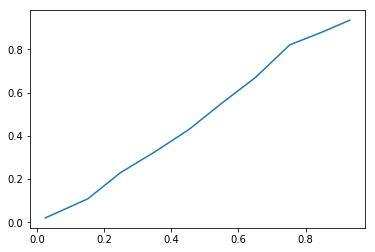

In [208]:
plot_calibration_curve(labels, proba, n_bins=10)

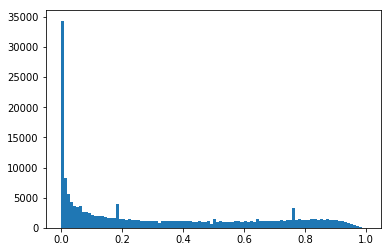

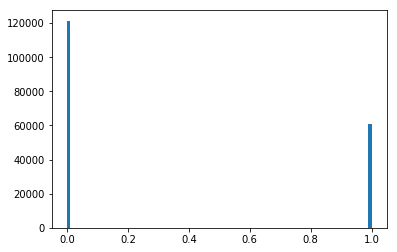

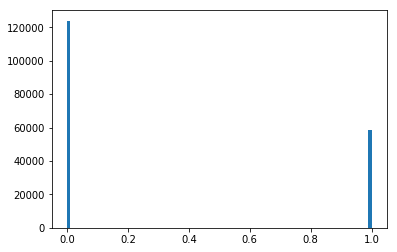

In [209]:
plt.hist(proba, bins=100)
plt.show()
plt.hist(preds, bins=100)
plt.show()
plt.hist(labels, bins=100)
plt.show()

In [210]:
clf = calibration.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv='prefit')

In [211]:
clf.fit(cal_data, labels)

CalibratedClassifierCV(base_estimator=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
            cv='prefit', method='sigmoid')

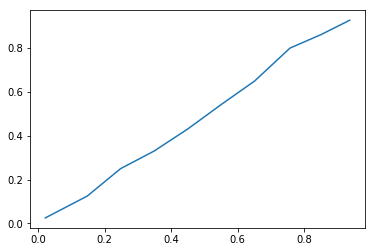

In [212]:
proba = clf.predict_proba(cal_data)[:,1]
preds = clf.predict(cal_data)
plot_calibration_curve(labels, proba, n_bins=10)

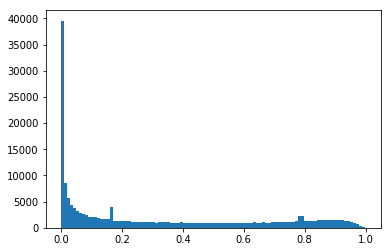

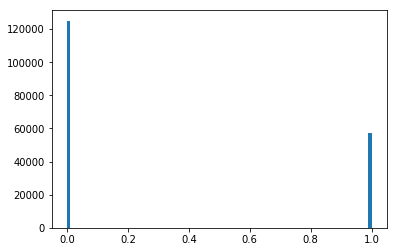

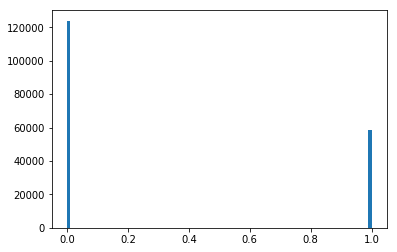

In [213]:
plt.hist(proba, bins=100)
plt.show()
plt.hist(preds, bins=100)
plt.show()
plt.hist(labels, bins=100)
plt.show()

In [292]:

data = df[(df['swings'] == 0) & (df['intentball'] == 0) & (df['hbp'] == 0) & (df['pitchout'] == 0)]
data.loc[:,'cs_prob'] = proba


In [293]:
data.to_csv('data_with_cs_prob.csv',index=False)

# Apply Generalized Linear Mixed Effects Model

In [294]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [295]:
filepath = 'data_with_cs_prob.csv'

In [296]:
df = pd.read_csv(filepath)

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182214 entries, 0 to 182213
Data columns (total 28 columns):
parkid               182214 non-null int64
bluejaysgameid       182214 non-null object
gamepitchsequence    182214 non-null int64
half                 182214 non-null int64
balls                182214 non-null int64
strikes              182214 non-null int64
pitcherid            182214 non-null int64
pitcherhand          182214 non-null object
batterid             182214 non-null int64
batside              182214 non-null object
catcherid            182214 non-null int64
pitchtype            182214 non-null object
relspeed             182214 non-null float64
hbreak               182214 non-null float64
vbreak               182214 non-null float64
plate_x              182214 non-null float64
plate_z              182214 non-null float64
calledstrike         182214 non-null int64
ball                 182214 non-null int64
swings               182214 non-null int64
takes          

In [299]:
import statsmodels
from scipy.stats import norm


In [301]:
random = {
    'ump_hp':'C(ump_hp)',
    'pitcherid':'C(pitcherid)',
    'batterid':'C(batterid)',
    'catcherid':'C(catcherid)'
}

model = sm.BinomialBayesMixedGLM.from_formula('calledstrike ~ cs_prob + half', random, df)

# change to probit link function

link = statsmodels.genmod.families.links.probit()
family = sm.genmod.families.family.Binomial(link=link)

model.family = family

In [302]:
model.vcp_p = 0.1
model.fe_p = 0.5

In [303]:
model_fitted = model.fit_vb(fit_method='BFGS', minim_opts=dict(norm=2, disp=True, gtol=500), verbose=True)
#model_fitted = model.fit_map(minim_opts=dict(norm=2, disp=True, gtol=10000))

|G|=86647.769104
|G|=64453.841490
|G|=57999.763867
|G|=44995.511523
|G|=112158.623711
|G|=45006.728928
|G|=44495.868098
|G|=44161.076698
|G|=43935.619236
|G|=43745.153591
|G|=43302.842909
|G|=42957.039229
|G|=43107.501345
|G|=42673.241654
|G|=142416.751392
|G|=42399.767636
|G|=41920.243585
|G|=40998.164207
|G|=40472.893088
|G|=39843.098347
|G|=39073.008044
|G|=37650.721864
|G|=35602.849465
|G|=34968.725654
|G|=35568.365633
|G|=34646.158967
|G|=33569.971936
|G|=31993.936871
|G|=29534.743484
|G|=27860.369899
|G|=25584.222003
|G|=22943.523232
|G|=20590.639961
|G|=18537.486019
|G|=17187.240350
|G|=16413.856443
|G|=15800.479760
|G|=15349.014912
|G|=15118.539474
|G|=14968.414509
|G|=14854.477626
|G|=14784.300223
|G|=14726.284538
|G|=14702.439968
|G|=14664.693647
|G|=14660.948336
|G|=14618.208439
|G|=14584.351019
|G|=14534.299363
|G|=14459.142092
|G|=14394.545214
|G|=14298.776393
|G|=14238.733015
|G|=14119.764309
|G|=13948.248740
|G|=13790.864608
|G|=13605.342857
|G|=13433.551752
|G|=13200.10

In [304]:
print(model_fitted.summary())

               Binomial Mixed GLM Results
          Type Post. Mean Post. SD   VC  VC (LB) VC (UB)
--------------------------------------------------------
Intercept    F    -0.7833   0.0688                      
cs_prob      F     6.3971   0.0097                      
half         F    -0.0715   0.0023                      
ump_hp       R    -0.5398   0.0320 0.583   0.547   0.621
pitcherid    R    -1.3045   0.0495 0.271   0.246   0.300
batterid     R    -1.6604   0.1410 0.190   0.143   0.252
catcherid    R    -0.8031   0.0940 0.448   0.371   0.541



In [231]:
1

1

In [305]:


def get_random_effect_factors(effect, random):
    # this will not work for interaction effects, only C(factor)
    factors = [col for col in model_fitted.random_effects().index if random[effect] in col and 'cs_prob' not in col]
    random_effect_factors = model_fitted.random_effects().loc[factors,['Mean','SD']]
    effect_intercept = convert_random_intercept_to_level(effect, random)
    return pd.concat([random_effect_factors, effect_intercept], axis=0)

def convert_random_intercept_to_level(effect, random):
    # it seems statsmodels dummy encoding manifests one of the levels as the Intercept, so 
    # we will need to extract the right Intercept term from the random effects parameters
    # and append that to the other random effects, associated with the correct level
    random_indexes = {r:i for i,r in enumerate(random)}
    effect_intercept = model_fitted.random_effects().loc['Intercept',['Mean','SD']]
    effect_intercept = effect_intercept.reset_index().loc[[random_indexes[effect]],['Mean','SD']]
    # get the level name
    missing_level = df[effect].unique()
    missing_level.sort()
    missing_level = missing_level[0]
    # put it together as new row
    effect_intercept.index = ['{}[T.{}]'.format(random[effect],missing_level)]
    effect_intercept
    return effect_intercept

def extract_id(array, id_name):
    return list(map(lambda x: x.replace('C({})'.format(id_name),'')[3:-1], array))

def plot_effect_factors(effect, random):
    
    factors = get_random_effect_factors(effect, random)
    mean = factors.sort_values('Mean', ascending=False)['Mean']
    std = factors.sort_values('Mean', ascending=False)['SD']

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0., 0., 1.4, 1.4, ])
    ax.bar(np.arange(len(mean)), mean, yerr=std)
    ax.set_ylabel('coeffs')
    ax.set_title('Random Effects - {}'.format(effect), fontdict={'fontsize':30})
    ax.set_xticks(np.arange(len(mean)))
    ax.set_xticklabels(extract_id(get_random_effect_factors(effect, random).sort_values('Mean', ascending=False).index, effect), fontdict={'rotation':75})

    fig.show()

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend

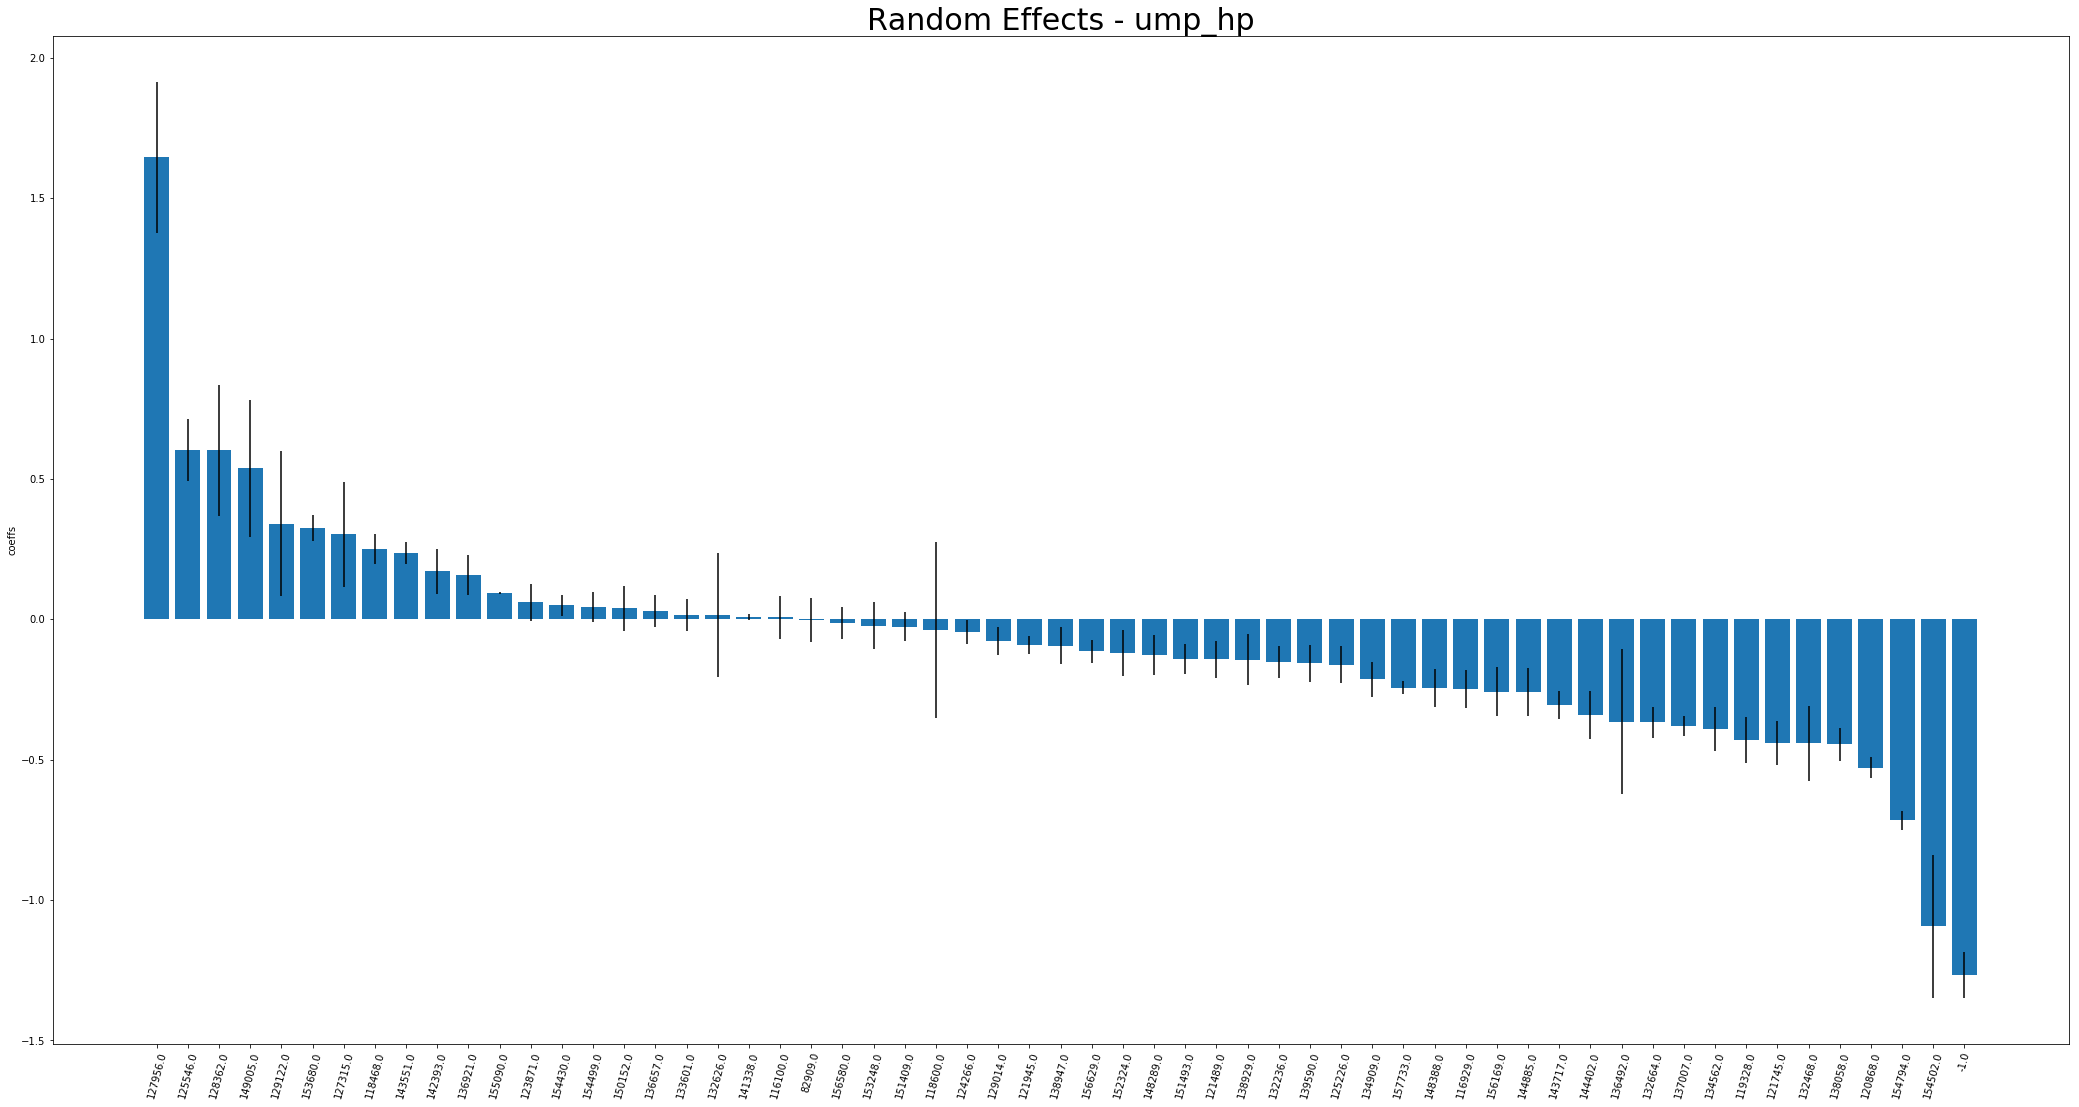

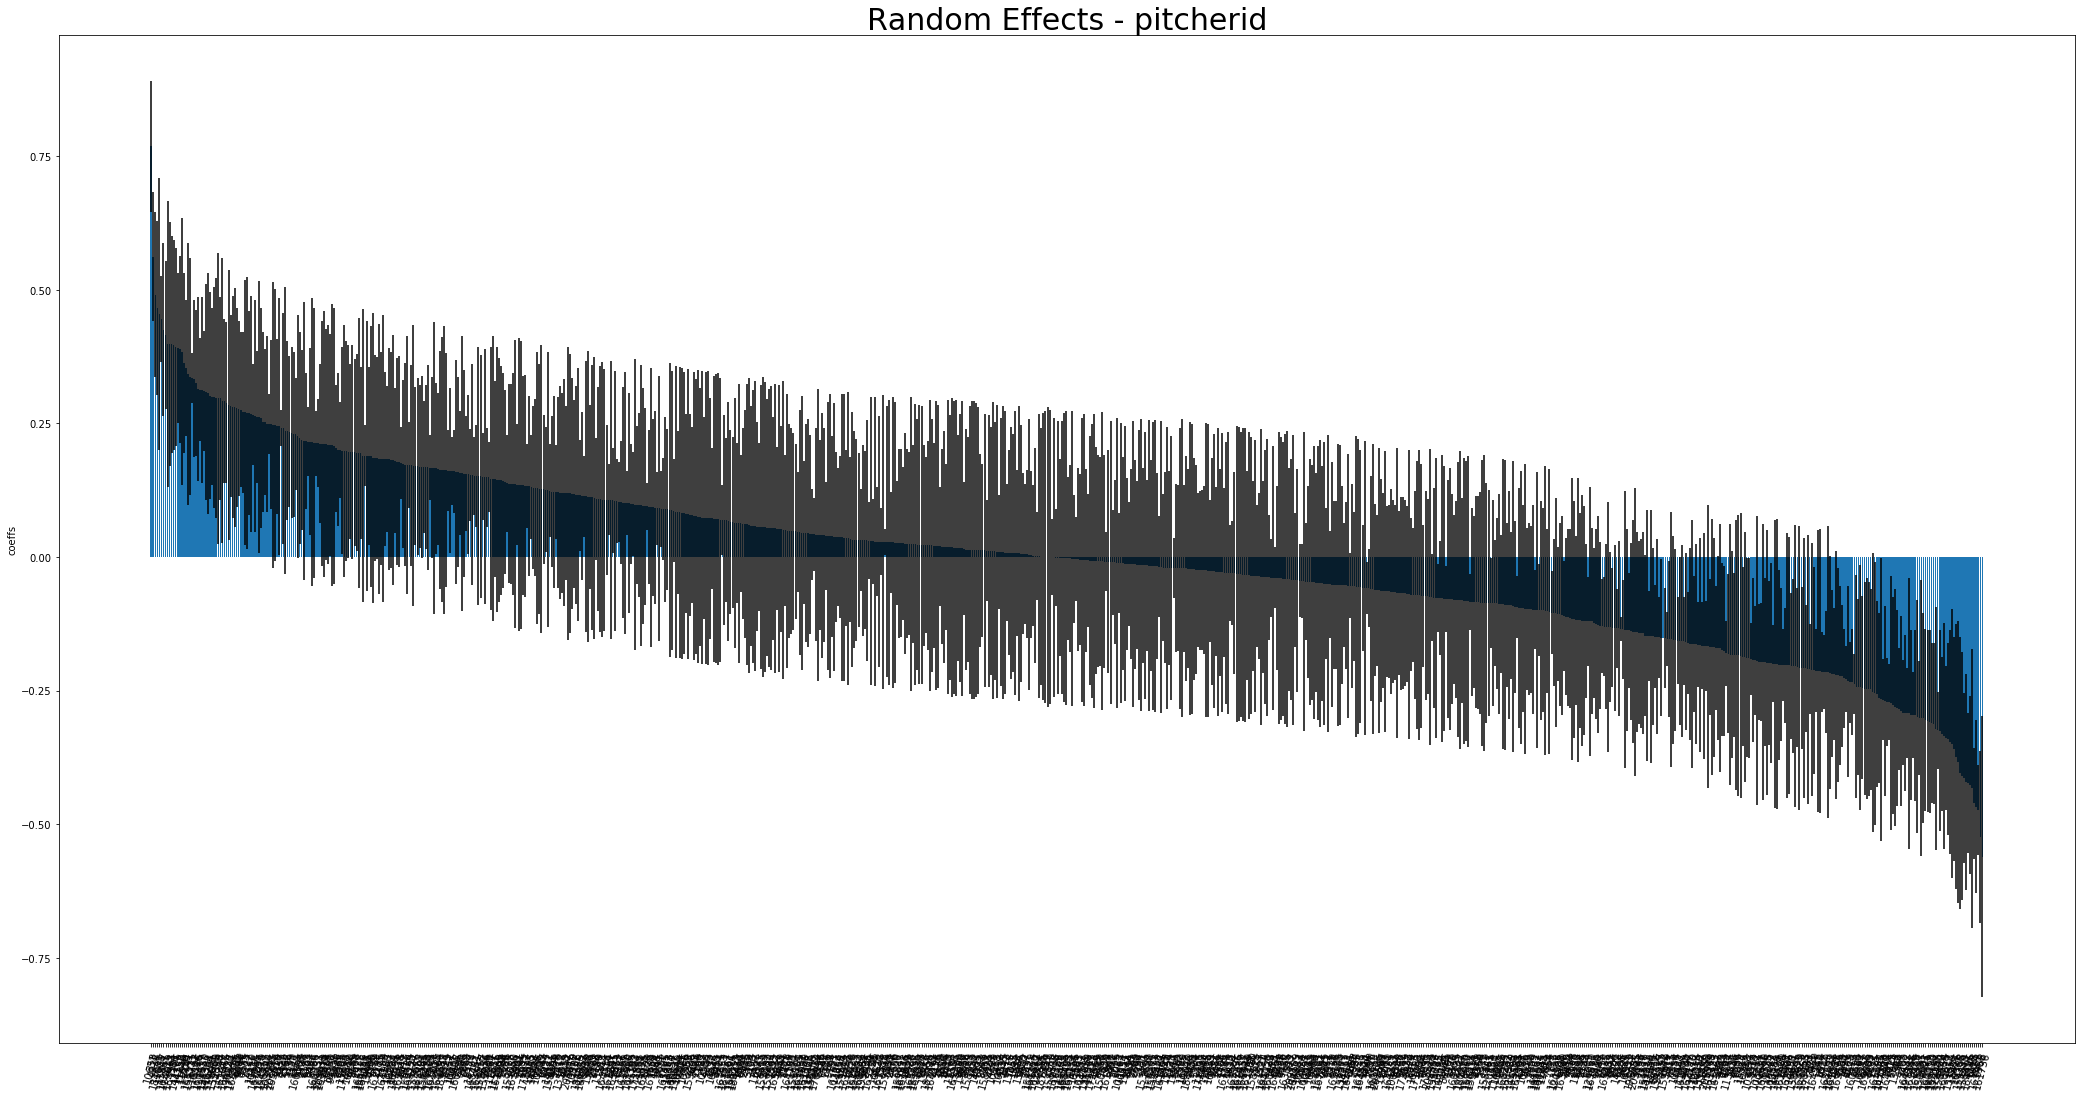

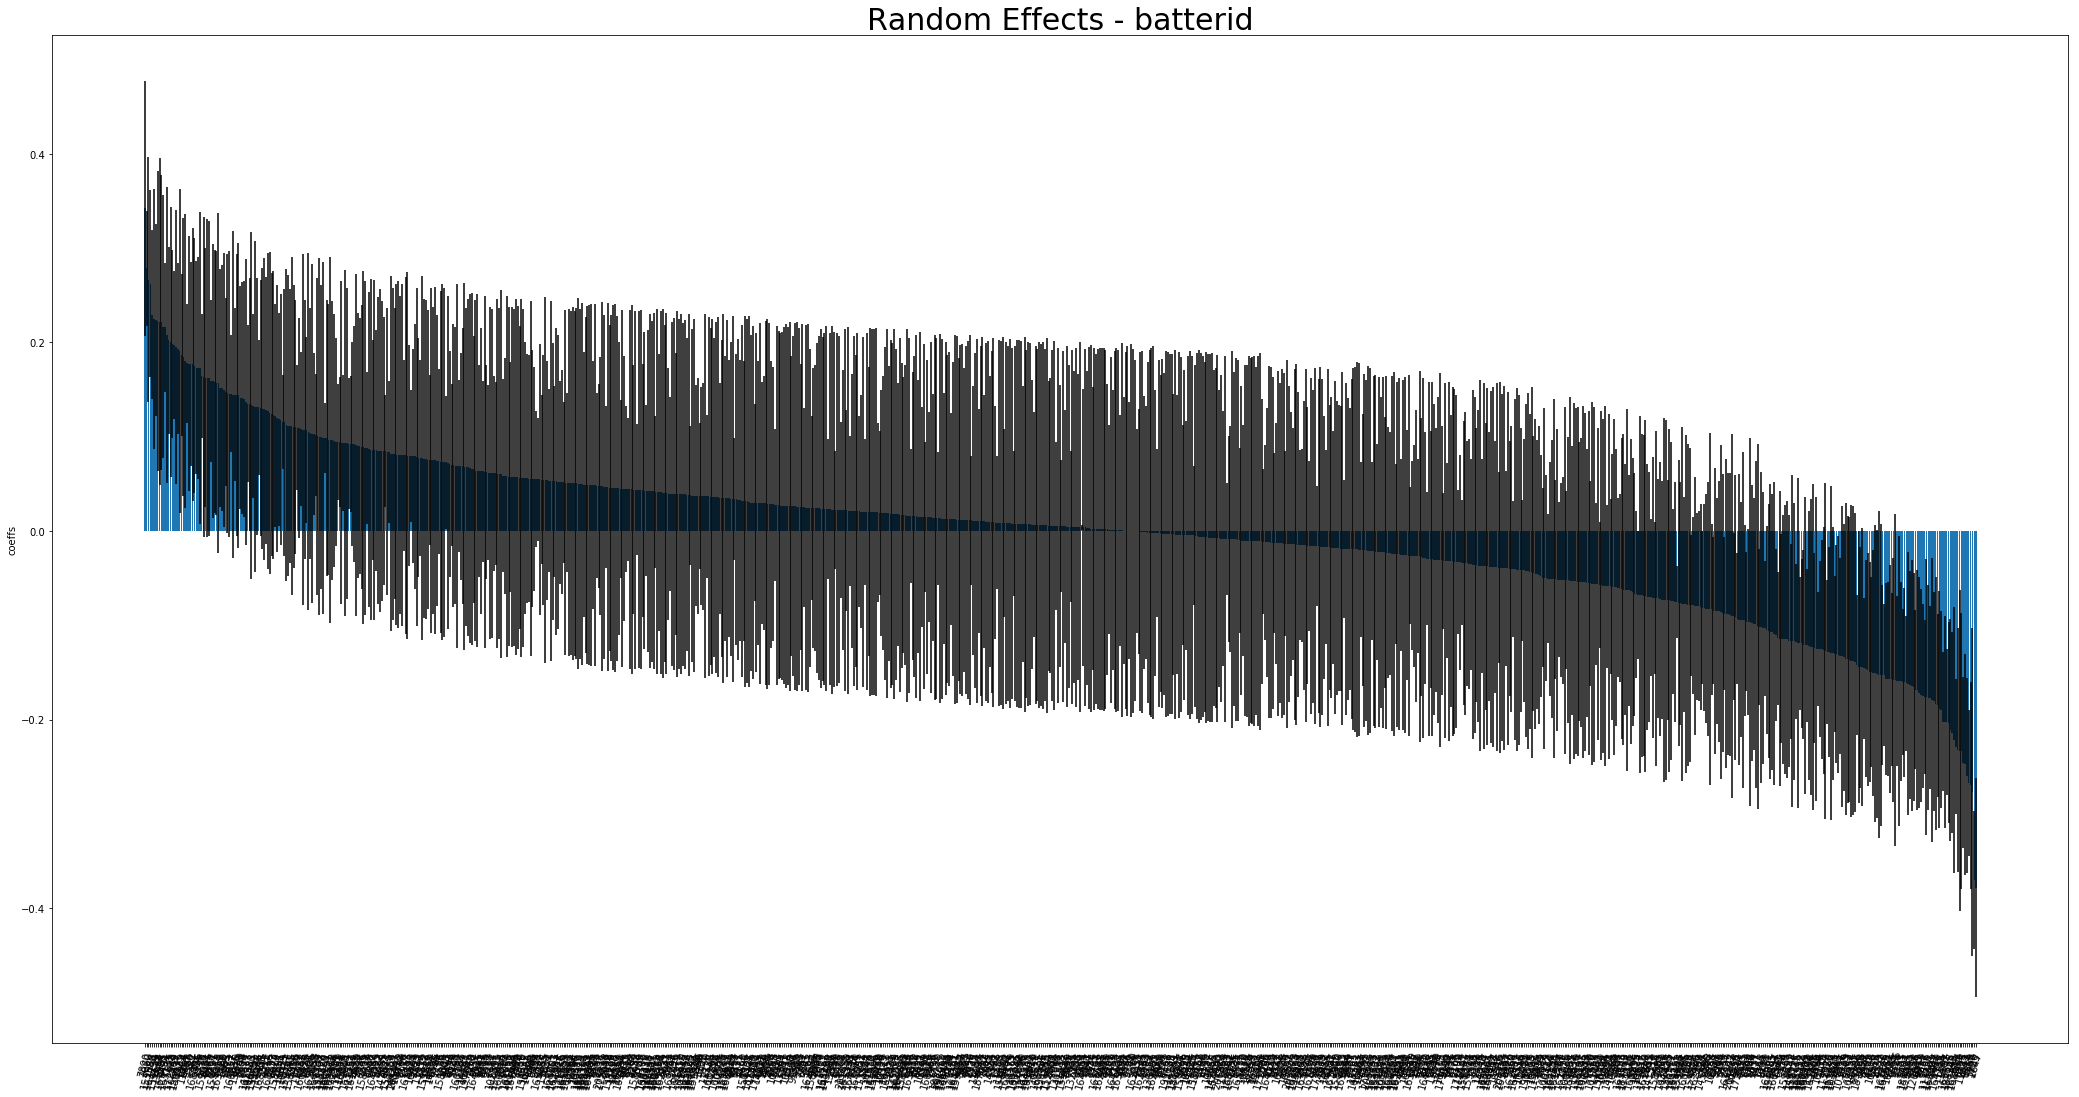

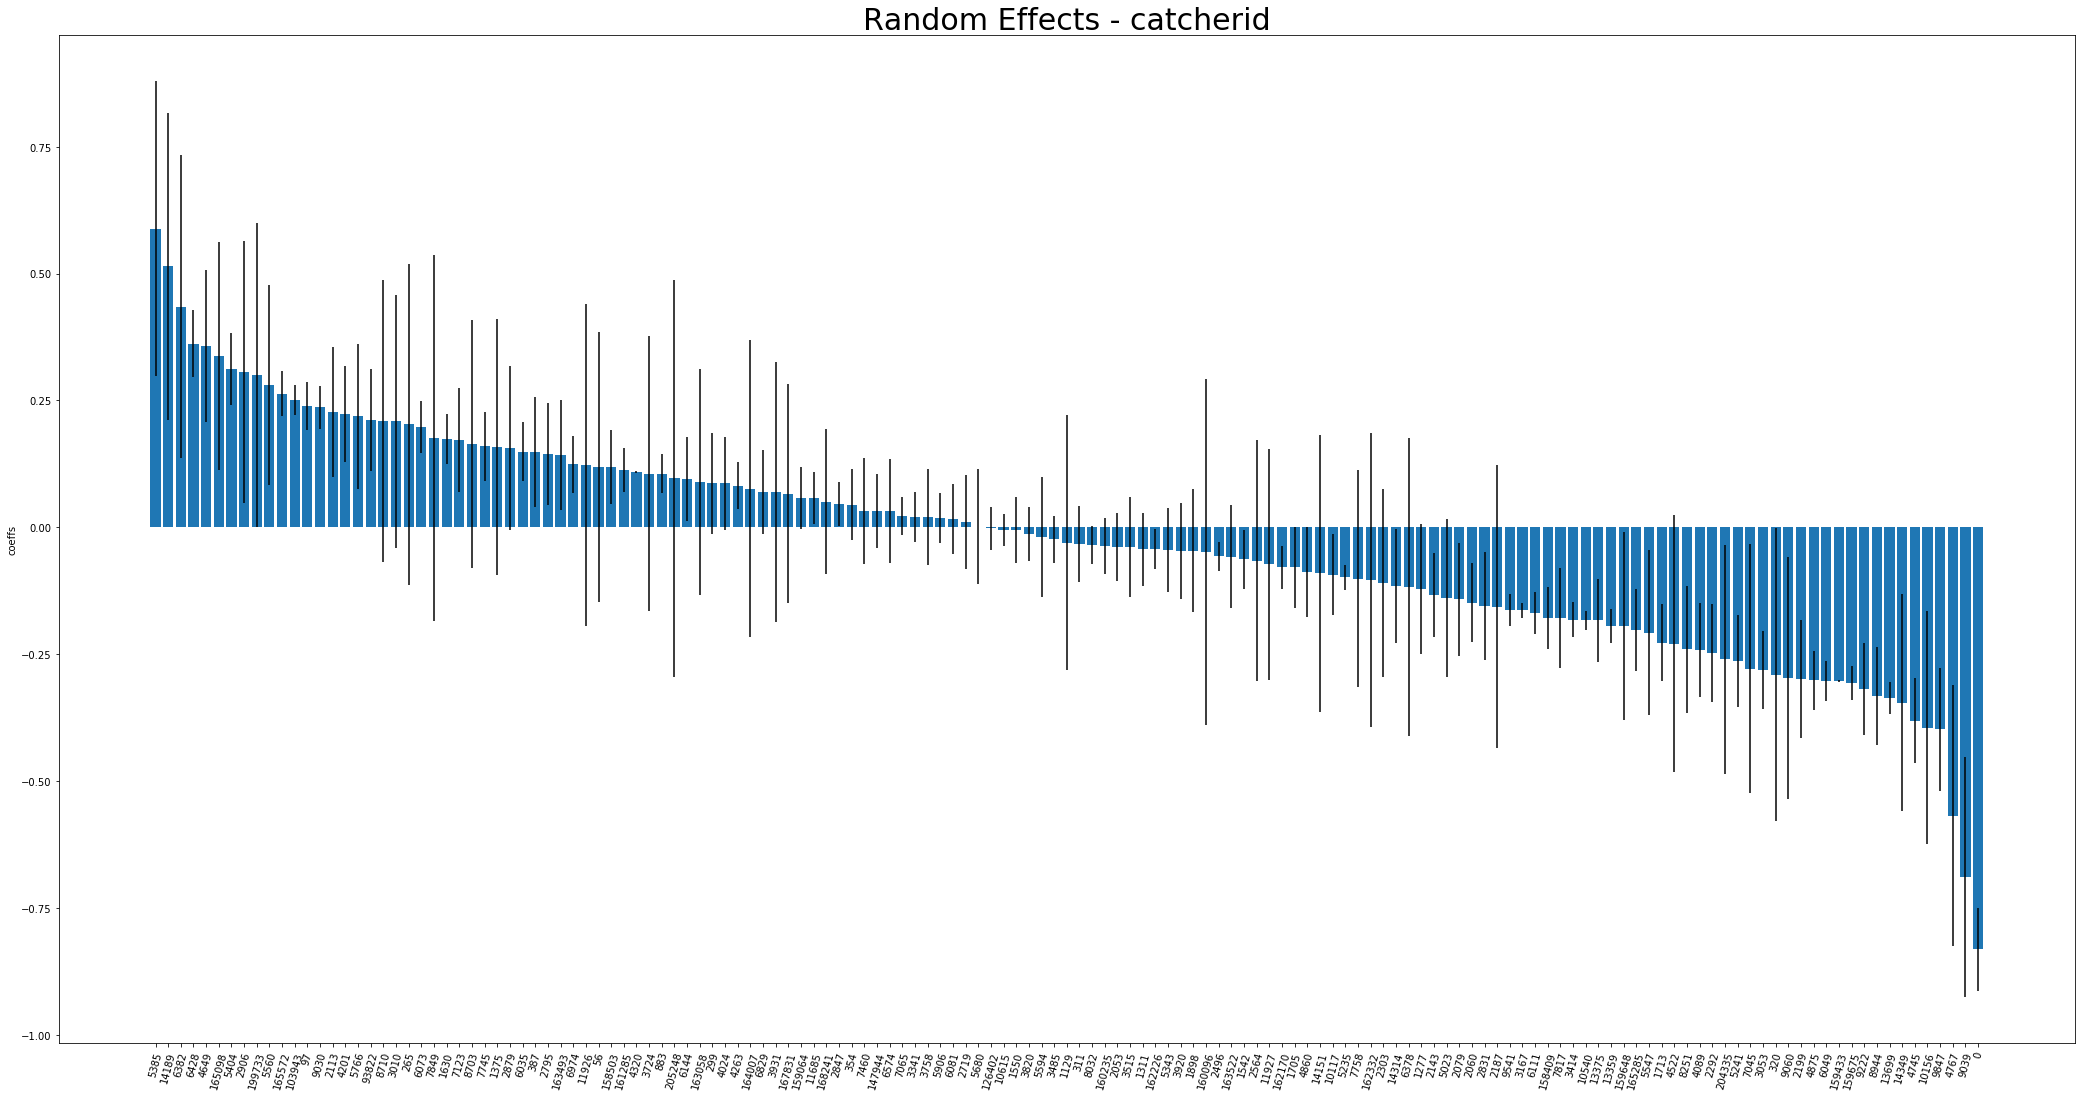

In [306]:
for effect in [
    'ump_hp',
    'pitcherid','batterid','catcherid'
]:
    plot_effect_factors(effect, random)

In [307]:
get_random_effect_factors('catcherid', random).sort_values('Mean',ascending=False)

,Mean,SD
C(catcherid)[T.5385],0.588214,0.290917
C(catcherid)[T.14189],0.514525,0.302271
C(catcherid)[T.6382],0.434261,0.298448
C(catcherid)[T.6428],0.361612,0.066279
C(catcherid)[T.4649],0.356561,0.149890
C(catcherid)[T.165098],0.337465,0.225055
C(catcherid)[T.5404],0.311241,0.071147
C(catcherid)[T.2906],0.306936,0.258116
C(catcherid)[T.199733],0.299754,0.298898
C(catcherid)[T.5560],0.280634,0.197108


In [268]:
np.mean(model.data.exog, axis=0)

array([ 1.00000000e+00, -8.04813292e-17,  4.87854940e-01])

In [308]:
fixed_effect = np.matmul(np.mean(model.data.exog, axis=0),model_fitted.fe_mean)
baseline_prob = norm.cdf(fixed_effect)

In [309]:
model_fitted.fe_mean

array([-0.78332191,  6.39709786, -0.07151874])

In [337]:
catchers = get_random_effect_factors('catcherid', random).sort_values('Mean',ascending=False)

In [338]:
def extract_id(df,id_name):
    return df[id_name].replace('C({})'.format(id_name),'')[3:-1]

In [339]:
catchers.reset_index(inplace=True)
catchers.rename(columns={'index':'catcherid'}, inplace=True)
catchers['catcherid'] = catchers.apply(extract_id, args=['catcherid'], axis=1)

In [340]:
def calc_random_effect_prob(df, sd_multiplier=0):
    z = df['Mean'] + (sd_multiplier * df['SD']) + fixed_effect
    return norm.cdf(z)

def calc_random_effect_prob_added(df, col):
    return df[col] - norm.cdf(fixed_effect)

In [341]:
catchers['prob'] = catchers.apply(calc_random_effect_prob, args=[0], axis=1)
catchers['runs_per_7000'] = catchers.apply(calc_random_effect_prob_added, args=['prob'], axis=1)

In [342]:
catchers['prob_ub'] = catchers.apply(calc_random_effect_prob, args=[1], axis=1)
catchers['runs_per_7000_ub'] = catchers.apply(calc_random_effect_prob_added, args=['prob_ub'], axis=1)
catchers['prob_lb'] = catchers.apply(calc_random_effect_prob, args=[-1], axis=1)
catchers['runs_per_7000_lb'] = catchers.apply(calc_random_effect_prob_added, args=['prob_lb'], axis=1)

In [344]:
output = catchers.set_index('catcherid')[['runs_per_7000','runs_per_7000_lb','runs_per_7000_ub']]*7000*0.14


chances = data.groupby('catcherid').count()[['bluejaysgameid']]
chances.rename(columns={'bluejaysgameid':'chances'}, inplace=True)

output = output.reset_index()
output['catcherid'] = output['catcherid'].astype(int)
output = output.set_index('catcherid')
output = pd.merge(output,chances,left_index=True,right_index=True)




In [345]:
output.to_csv('catcher_framing_ratings.csv')

In [347]:
output

,runs_per_7000,runs_per_7000_lb,runs_per_7000_ub,chances
catcherid,,,,
5385,73.370474,45.104326,90.088862,69
14189,67.469458,34.052896,87.272029,57
6382,60.119081,22.892159,82.858311,54
6428,52.563462,44.864622,59.491928,1097
4649,52.004523,33.277938,66.774944,421
165098,49.850377,19.232454,71.400345,169
5404,46.785350,37.824837,54.815812,2617
2906,46.270185,8.694286,71.598615,117
199733,45.403196,0.157108,74.144972,77
